In [121]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)  

In [122]:
from lifelines import KaplanMeierFitter,CoxPHFitter
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines.statistics import logrank_test, pairwise_logrank_test, multivariate_logrank_test
from sklearn.model_selection import KFold
from sksurv.metrics import concordance_index_censored
from lifelines.utils import concordance_index
import re

In [123]:
from astropy.table import Table

In [124]:
import os

OUTPUT_DIR = r"/Users/heinamchan/Documents/GitHub/bio275/Project/result/"

# Import data

In [125]:
# Dataset
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
aids_clinical_trials_group_study_175 = fetch_ucirepo(id=890) 
  
# data (as pandas dataframes) 
X = aids_clinical_trials_group_study_175.data.features 
y = aids_clinical_trials_group_study_175.data.targets 

In [126]:
X_history = X.loc[X["str2"]==1].reset_index(drop=True)
X_no_history = X.loc[X["str2"]==0].reset_index(drop=True)
y_history = y.loc[X["str2"]==1].reset_index(drop=True)
y_no_history = y.loc[X["str2"]==0].reset_index(drop=True)

In [127]:
dict_trt = {0:"ZDV only",1:"ZDV + ddI",2:"ZDV + Zal", 3:"ddI only"}

XLIM_LOW = 0
XLIM_HIGH = X["time"].max()

In [128]:
dict_cox_trt = {"trt_1":"ZDV + ddI","trt_2":"ZDV + Zal", "trt_3":"ddI only"}


In [129]:
# convert raw cox result table to polished one
def cox_result_excel(model, file_name):
    # write to the new tex document
    texdoc = model.summary.to_latex()
    with open(os.path.join(OUTPUT_DIR,f"tex/{file_name}.tex"), 'w') as fout:
        for i in range(len(texdoc)):
            fout.write(texdoc[i])
    
    # read tex file to pandas 
    df = Table.read(os.path.join(OUTPUT_DIR,f"tex/{file_name}.tex")).to_pandas()
    
    # change col names    
    df.loc[:,"col0"] = df["col0"].apply(lambda x: "antiretroviral history" if x == "str2" else dict_cox_trt.get(x[:3]+x[-2:],x))
    df.columns = ["Feature", 
               "Coefficient", 
               "Hazard ratio", 
               "Standard error (coef)",
               "Coefficient (95% CI lower)",
               "Coefficient (95% CI upper)",
               "Hazard ratio (95% CI lower)",
               "Hazard ratio (95% CI upper)",
               "cmp to",
               "Z statistics",
               "p-value",
               "-log2(p)"
              ]
    # save to excel
    df.to_excel(os.path.join(OUTPUT_DIR,f"{file_name}.xlsx"))
    return df

In [130]:
sns.set_theme()

# Survival analysis of reaching primary end point

## A. KM estimate and Log rank test

#### All patients

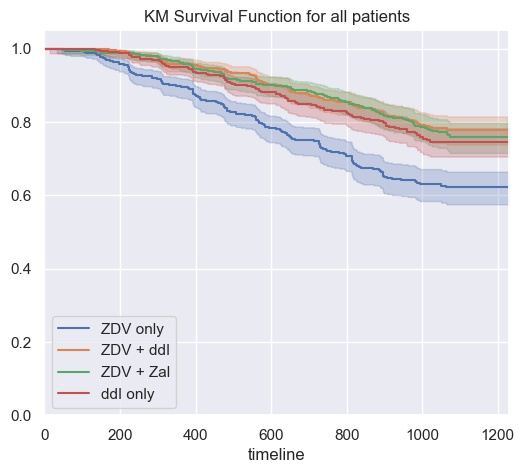

In [131]:
km = KaplanMeierFitter()
fig, ax = plt.subplots(figsize=(6,5))

# Plot KM curve for each treatment group
for trt in sorted(X["trt"].unique().tolist()):
    temp_X = X.loc[X["trt"]==trt,"time"]
    temp_y = y.loc[X["trt"]==trt]
    km_trt = km.fit(temp_X, temp_y)
    
    km_trt.plot(label=dict_trt.get(trt), ax=ax)
    ax.set_ylim(0,1.05)
    ax.set_xlim(XLIM_LOW,XLIM_HIGH)
    ax.set_title("KM Survival Function for all patients")
    
#     km_trt.plot_cumulative_density(label=dict_trt.get(trt), ax=ax[1])
#     ax[1].set_ylim(0,1.05)
#     ax[1].set_xlim(XLIM_LOW,XLIM_HIGH)


In [132]:
log_rank_result = multivariate_logrank_test(X['time'], X['trt'], y['cid'])

In [133]:
log_rank_result

<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 3
         test_name = multivariate_logrank_test

---
 test_statistic      p  -log2(p)
          49.19 <0.005     32.97

In [134]:
print(f"p-value: {log_rank_result.p_value}")

p-value: 1.1860553904066105e-10


Null hypothesis of all groups having the same survival distribution is rejected.

#### Patients with antiretroviral history

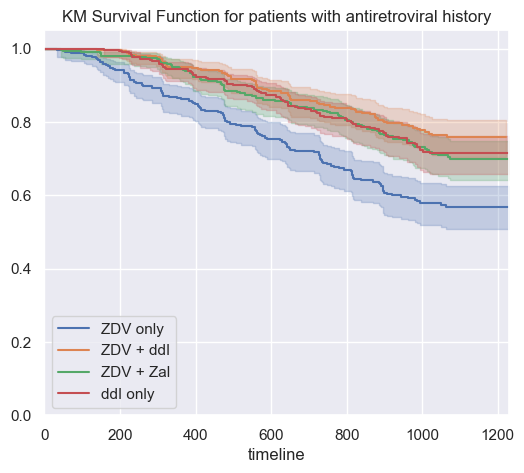

In [135]:
km = KaplanMeierFitter()
fig, ax = plt.subplots(figsize=(6,5))

# Plot KM curve for each treatment group
for trt in sorted(X_history["trt"].unique().tolist()):
    temp_X = X_history.loc[X_history["trt"]==trt,"time"]
    temp_y = y_history.loc[X_history["trt"]==trt]
    km_trt = km.fit(temp_X, temp_y)
    
    km_trt.plot(label=dict_trt.get(trt), ax=ax)
    ax.set_ylim(0,1.05)
    ax.set_xlim(XLIM_LOW,XLIM_HIGH)
    ax.set_title("KM Survival Function for patients with antiretroviral history")
    


In [136]:
log_rank_result = multivariate_logrank_test(X_history['time'], X_history['trt'], y_history['cid'])
log_rank_result

<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 3
         test_name = multivariate_logrank_test

---
 test_statistic      p  -log2(p)
          33.93 <0.005     22.22

In [137]:
print(f"p-value: {log_rank_result.p_value}")

p-value: 2.04720955538904e-07


Null hypothesis of all groups with antiretroviral history having the same survival distribution is rejected.

#### Patients without antiretroviral history

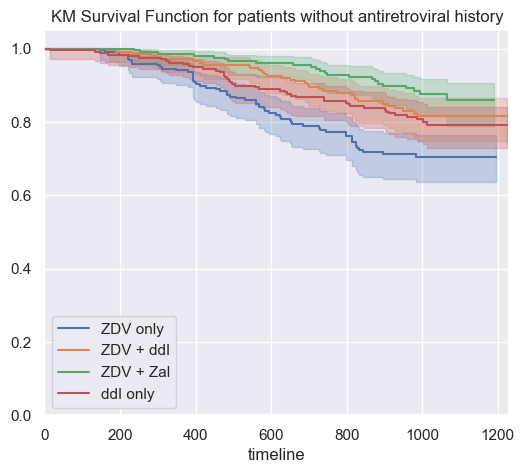

In [138]:
km = KaplanMeierFitter()
fig, ax = plt.subplots(figsize=(6,5))

# Plot KM curve for each treatment group
for trt in sorted(X_no_history["trt"].unique().tolist()):
    temp_X = X_no_history.loc[X_no_history["trt"]==trt,"time"]
    temp_y = y_no_history.loc[X_no_history["trt"]==trt]
    km_trt = km.fit(temp_X, temp_y)
    
    km_trt.plot(label=dict_trt.get(trt), ax=ax)
    ax.set_ylim(0,1.05)
    ax.set_xlim(XLIM_LOW,XLIM_HIGH)
    ax.set_title("KM Survival Function for patients without antiretroviral history")

In [139]:
log_rank_result = multivariate_logrank_test(X_no_history['time'], X_no_history['trt'], y_no_history['cid'])
log_rank_result

<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 3
         test_name = multivariate_logrank_test

---
 test_statistic      p  -log2(p)
          21.31 <0.005     13.42

In [140]:
print(f"p-value: {log_rank_result.p_value}")

p-value: 9.095096373417143e-05


Null hypothesis of all groups without antiretroviral history having the same survival distribution is rejected.


## C. Cox proportional-hazards model

In [141]:
dummies_trt = pd.get_dummies(X["trt"], prefix = 'trt')

In [142]:
y_boolean = y.copy()
y_boolean["cid"] = y["cid"].astype(bool)

In [143]:
# adjust for treatment category since it is more than 2
X_cox_all = pd.concat([X[['time',"trt","str2"]], dummies_trt, y_boolean], axis = 1)

# drop base category (treatment 0 = ZDV only)
X_cox_all = X_cox_all.drop(["trt_0","trt"], axis=1)

# not keep str2 column
X_cox = X_cox_all.drop(["str2"], axis=1)
X_cox.head()

,time,trt_1,trt_2,trt_3,cid
0,948,0,1,0,False
1,1002,0,0,1,True
2,961,0,0,1,False
3,1166,0,0,1,False
4,1090,0,0,0,False


In [144]:
X_cox_history = X_cox_all.loc[X_cox_all["str2"]==1].drop(["str2"],axis=1)
X_cox_no_history = X_cox_all.loc[X_cox_all["str2"]==0].drop(["str2"],axis=1)

#### All patients

In [145]:
cph = CoxPHFitter()
cph.fit(X_cox, duration_col = 'time', event_col = 'cid')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 2139 total observations, 1618 right-censored observations>
             duration col = 'time'
                event col = 'cid'
      baseline estimation = breslow
   number of observations = 2139
number of events observed = 521
   partial log-likelihood = -3843.41
         time fit was run = 2024-11-20 04:18:12 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
trt_1      -0.71       0.49       0.12            -0.95            -0.47                 0.39                 0.63
trt_2      -0.64       0.52       0.12            -0.88            -0.41                 0.41                 0.67
trt_3      -0.53       0.59       0.12            -0.76            -0.31                 0.47                 0.73

            cmp to     z      p   -log2(p)
covariate                                 
trt_1         0.00 -5.74 <0.005      26.70
trt_2         0.00 -5.31 <0.005      23.16
trt_3         0.00 -4.63 <0.005      18.05
---
Concordance = 0.58
Partial AIC = 7692.82
log-likelihood ratio test = 44.59 on 3 df
-log2(p) of ll-ratio test = 29.72

In [146]:
# save to excel
_ = cox_result_excel(cph, "3C1_Cox_all_result")

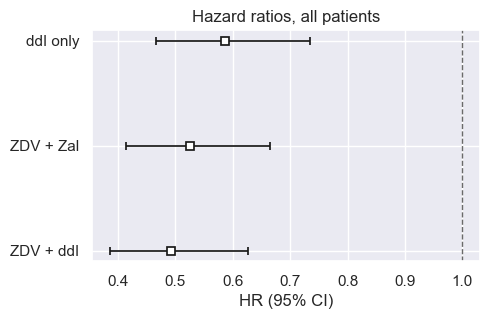

In [147]:
fig, ax = plt.subplots(figsize = (5, 3))
cph.plot(hazard_ratios=True, ax=ax)
ax.set_title("Hazard ratios, all patients")
# ax.set_xlim(0,1)

labels = [item.get_text() for item in ax.get_yticklabels()]
labels = [dict_cox_trt.get(label) for label in labels]

_ = ax.set_yticklabels(labels)

In [148]:
cph.predict_expectation(X_cox)

0       1074.637686
1       1059.812238
2       1059.812238
3       1059.812238
4        967.207880
           ...     
2134    1059.812238
2135     967.207880
2136    1074.637686
2137     967.207880
2138    1059.812238
Length: 2139, dtype: float64

In [149]:
cph.predict_log_partial_hazard(X_cox)

0      -0.173332
1      -0.063493
2      -0.063493
3      -0.063493
4       0.471291
          ...   
2134   -0.063493
2135    0.471291
2136   -0.173332
2137    0.471291
2138   -0.063493
Length: 2139, dtype: float64

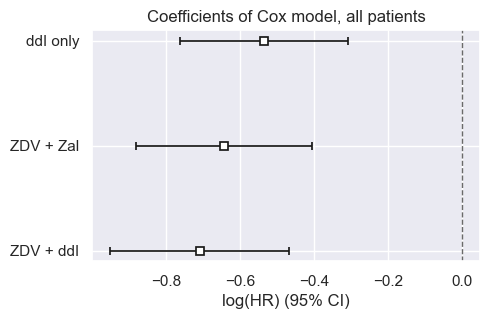

In [150]:
fig, ax = plt.subplots(figsize = (5, 3))
cph.plot(hazard_ratios=False, ax=ax)
ax.set_title("Coefficients of Cox model, all patients")
# ax.set_xlim(0,1)

labels = [item.get_text() for item in ax.get_yticklabels()]
labels = [dict_cox_trt.get(label) for label in labels]

_ = ax.set_yticklabels(labels)

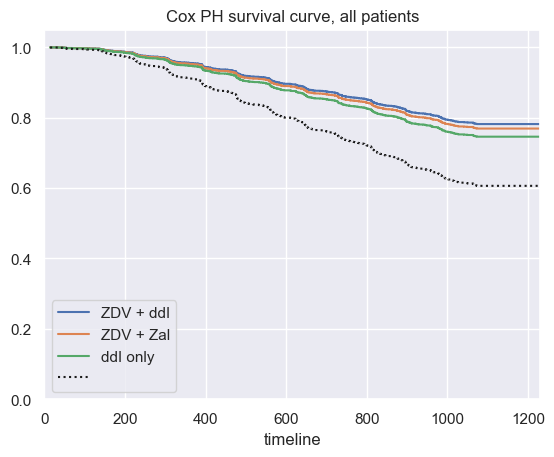

In [151]:
# Produces a plot comparing the baseline curve of the model versus 
# what happens when a covariate(s) is varied over values in a group

cph.plot_partial_effects_on_outcome(covariates=['trt_1', 'trt_2', 'trt_3'], 
                                    values = np.eye(3))

plt.title("Cox PH survival curve, all patients")
plt.xlabel("timeline")
plt.xlim(XLIM_LOW,XLIM_HIGH)
plt.ylim(0,1.05)

for idx, l in enumerate(plt.legend().texts):
    l.set_text(dict_cox_trt.get(l.get_text()[:5]))

#### With antiretroviral history

In [152]:
cph = CoxPHFitter()
cph.fit(X_cox_history, duration_col = 'time', event_col = 'cid')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 1253 total observations, 892 right-censored observations>
             duration col = 'time'
                event col = 'cid'
      baseline estimation = breslow
   number of observations = 1253
number of events observed = 361
   partial log-likelihood = -2468.75
         time fit was run = 2024-11-20 04:18:13 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
trt_1      -0.77       0.46       0.15            -1.07            -0.48                 0.34                 0.62
trt_2      -0.53       0.59       0.14            -0.80            -0.25                 0.45                 0.78
trt_3      -0.57       0.57       0.14            -0.85            -0.29                 0.43                 0.75

            cmp to     z      p   -log2(p)
covariate                                 
trt_1         0.00 -5.12 <0.005      21.66
trt_2         0.00 -3.74 <0.005      12.39
trt_3         0.00 -4.01 <0.005      14.01
---
Concordance = 0.58
Partial AIC = 4943.49
log-likelihood ratio test = 31.08 on 3 df
-log2(p) of ll-ratio test = 20.22

In [153]:
# save to excel
_ = cox_result_excel(cph, "3C2_Cox_history_result")

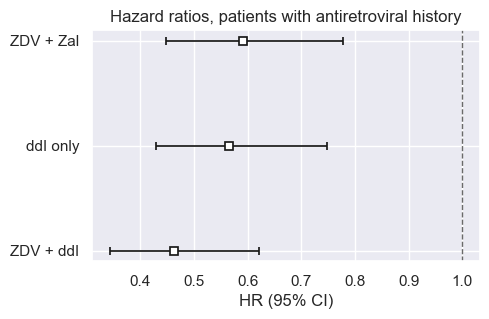

In [154]:
fig, ax = plt.subplots(figsize = (5, 3))
cph.plot(hazard_ratios=True, ax=ax)
ax.set_title("Hazard ratios, patients with antiretroviral history")
# ax.set_xlim(0,1)

labels = [item.get_text() for item in ax.get_yticklabels()]
labels = [dict_cox_trt.get(label) for label in labels]

_ = ax.set_yticklabels(labels)

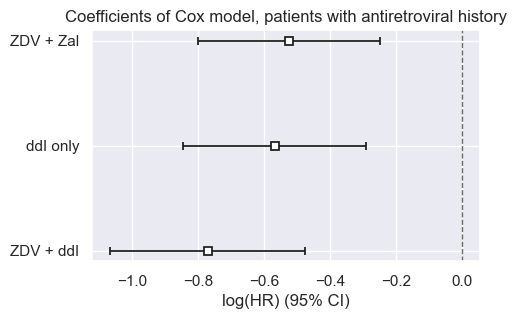

In [155]:
fig, ax = plt.subplots(figsize = (5, 3))
cph.plot(hazard_ratios=False, ax=ax)
ax.set_title("Coefficients of Cox model, patients with antiretroviral history")
# ax.set_xlim(0,1)

labels = [item.get_text() for item in ax.get_yticklabels()]
labels = [dict_cox_trt.get(label) for label in labels]

_ = ax.set_yticklabels(labels)

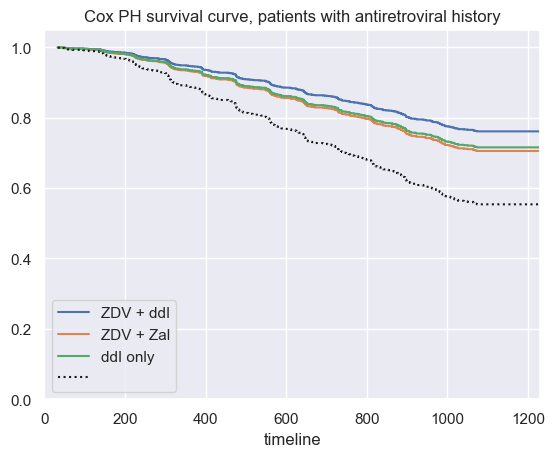

In [156]:
# Produces a plot comparing the baseline curve of the model versus 
# what happens when a covariate(s) is varied over values in a group

cph.plot_partial_effects_on_outcome(covariates=['trt_1', 'trt_2', 'trt_3'], 
                                    values = np.eye(3))

plt.title("Cox PH survival curve, patients with antiretroviral history")
plt.xlabel("timeline")
plt.xlim(XLIM_LOW,XLIM_HIGH)
plt.ylim(0,1.05)

for idx, l in enumerate(plt.legend().texts):
    l.set_text(dict_cox_trt.get(l.get_text()[:5]))

#### Without antiretroviral history

In [181]:
cph = CoxPHFitter()
cph.fit(X_cox_no_history, duration_col = 'time', event_col = 'cid')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 886 total observations, 726 right-censored observations>
             duration col = 'time'
                event col = 'cid'
      baseline estimation = breslow
   number of observations = 886
number of events observed = 160
   partial log-likelihood = -1038.04
         time fit was run = 2024-11-20 06:19:17 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
trt_1      -0.62       0.54       0.22            -1.04            -0.20                 0.35                 0.82
trt_2      -1.03       0.36       0.25            -1.51            -0.54                 0.22                 0.58
trt_3      -0.47       0.63       0.20            -0.86            -0.08                 0.42                 0.92

            cmp to     z      p   -log2(p)
covariate                                 
trt_1         0.00 -2.87 <0.005       7.92
trt_2         0.00 -4.17 <0.005      15.00
trt_3         0.00 -2.36   0.02       5.76
---
Concordance = 0.61
Partial AIC = 2082.09
log-likelihood ratio test = 20.59 on 3 df
-log2(p) of ll-ratio test = 12.93

In [182]:
# save to excel
_ = cox_result_excel(cph, "3C3_Cox_no_history_result")

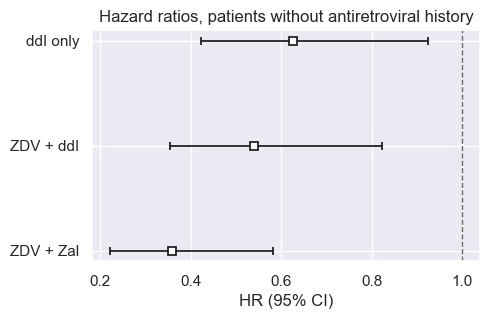

In [183]:
fig, ax = plt.subplots(figsize = (5, 3))
cph.plot(hazard_ratios=True, ax=ax)
ax.set_title("Hazard ratios, patients without antiretroviral history")
# ax.set_xlim(0,1)

labels = [item.get_text() for item in ax.get_yticklabels()]
labels = [dict_cox_trt.get(label) for label in labels]

_ = ax.set_yticklabels(labels)

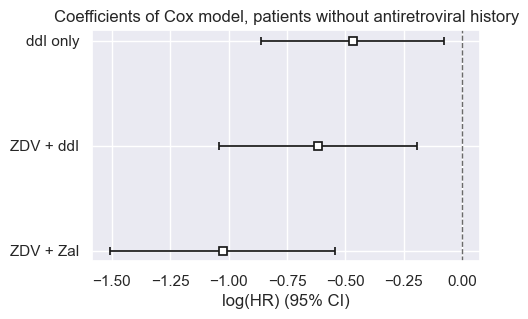

In [184]:
fig, ax = plt.subplots(figsize = (5, 3))
cph.plot(hazard_ratios=False, ax=ax)
ax.set_title("Coefficients of Cox model, patients without antiretroviral history")
# ax.set_xlim(0,1)

labels = [item.get_text() for item in ax.get_yticklabels()]
labels = [dict_cox_trt.get(label) for label in labels]

_ = ax.set_yticklabels(labels)

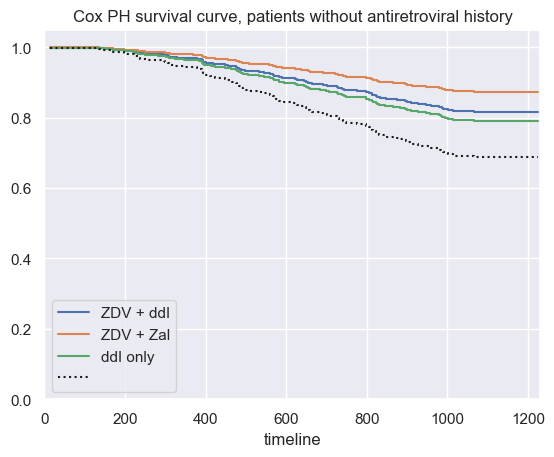

In [185]:
# Produces a plot comparing the baseline curve of the model versus 
# what happens when a covariate(s) is varied over values in a group

cph.plot_partial_effects_on_outcome(covariates=['trt_1', 'trt_2', 'trt_3'], 
                                    values = np.eye(3))

plt.title("Cox PH survival curve, patients without antiretroviral history")
plt.xlabel("timeline")
plt.xlim(XLIM_LOW,XLIM_HIGH)
plt.ylim(0,1.05)

for idx, l in enumerate(plt.legend().texts):
    l.set_text(dict_cox_trt.get(l.get_text()[:5]))

## D. Model Evaluation

Use concordance index to evaluate model via cross validation

In [162]:
# Initialize KFold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=20)

#### Cox proportional-hazards Model - only treatment and history feature

In [163]:
# cross validation for calculating concordance index

# Perform cross-validation
c_indices = []
for train_index, test_index in kf.split(X_cox):
    X_train, X_test = X_cox_all.iloc[train_index], X_cox_all.iloc[test_index]
    
    cph = CoxPHFitter()
    cph.fit(X_train, duration_col = 'time', event_col = 'cid')
    c_indices.append(cph.score(X_test, 'concordance_index'))
    
print(f"CV score: {np.mean(c_indices)}")

CV score: 0.6041475442438727


In [164]:
cph = CoxPHFitter()
cph.fit(X_cox_all, duration_col = 'time', event_col = 'cid')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 2139 total observations, 1618 right-censored observations>
             duration col = 'time'
                event col = 'cid'
      baseline estimation = breslow
   number of observations = 2139
number of events observed = 521
   partial log-likelihood = -3829.82
         time fit was run = 2024-11-20 04:18:16 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
str2        0.48       1.62       0.10             0.30             0.67                 1.34                 1.95
trt_1      -0.72       0.48       0.12            -0.97            -0.48                 0.38                 0.62
trt_2      -0.66       0.52       0.12            -0.89            -0.42                 0.41                 0.66
trt_3      -0.54       0.58       0.12            -0.76            -0.31                 0.47                 0.73

            cmp to     z      p   -log2(p)
covariate                                 
str2          0.00  5.07 <0.005      21.30
trt_1         0.00 -5.87 <0.005      27.74
trt_2         0.00 -5.40 <0.005      23.84
trt_3         0.00 -4.65 <0.005      18.18
---
Concordance = 0.61
Partial AIC = 7667.64
log-likelihood ratio test = 71.77 on 4 df
-log2(p) of ll-ratio test = 46.57

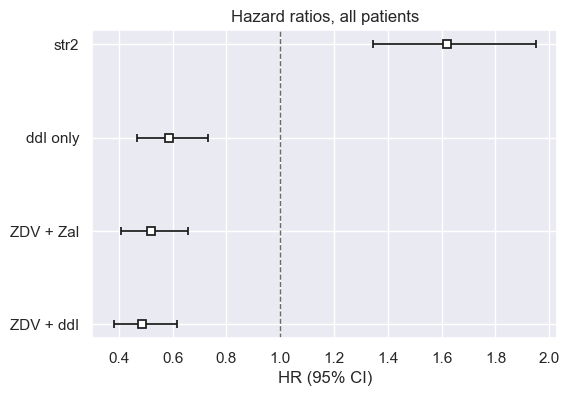

In [165]:
fig, ax = plt.subplots(figsize = (6, 4))
cph.plot(hazard_ratios=True, ax=ax)
ax.set_title("Hazard ratios, all patients")
# ax.set_xlim(0,1)

labels = [item.get_text() for item in ax.get_yticklabels()]
labels = [dict_cox_trt.get(label,label) for label in labels]

_ = ax.set_yticklabels(labels)

#### Cox proportional-hazards Model - with further features

In [166]:
# cross validation for calculating concordance index

X_cox_all_extra = pd.concat([X_cox_all,X[["karnof","hemo","homo","drugs","gender","race"]]], axis=1)
# Perform cross-validation
c_indices = []
for train_index, test_index in kf.split(X_cox_all_extra):
    X_train, X_test = X_cox_all_extra.iloc[train_index], X_cox_all_extra.iloc[test_index]
    
    cph = CoxPHFitter()
    cph.fit(X_train, duration_col = 'time', event_col = 'cid')
    c_indices.append(cph.score(X_test, 'concordance_index'))
    
print(f"CV score: {np.mean(c_indices)}")

CV score: 0.6163248770388166


In [167]:
cph = CoxPHFitter()
cph.fit(X_cox_all_extra, duration_col = 'time', event_col = 'cid')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 2139 total observations, 1618 right-censored observations>
             duration col = 'time'
                event col = 'cid'
      baseline estimation = breslow
   number of observations = 2139
number of events observed = 521
   partial log-likelihood = -3815.38
         time fit was run = 2024-11-20 04:18:17 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
str2        0.46       1.58       0.10             0.27             0.65                 1.31                 1.91
trt_1      -0.71       0.49       0.12            -0.95            -0.46                 0.39                 0.63
trt_2      -0.62       0.54       0.12            -0.86            -0.38                 0.42                 0.68
trt_3      -0.54       0.58       0.12            -0.77            -0.31                 0.47                 0.73
karnof     -0.03       0.97       0.01            -0.05            -0.02                 0.95                 0.98
hemo       -0.09       0.91       0.21            -0.51             0.32                 0.60                 1.38
homo        0.02       1.02       0.16            -0.29             0.34                 0.75                 1.40
drugs      -0.27       0.76       0.15            -0.57             0.02                 0.56                 1.02
gender      0.16       1.17       0.18            -0.20             0.52                 0.82                 1.68
race       -0.08       0.92       0.11            -0.30             0.13                 0.74                 1.14

            cmp to     z      p   -log2(p)
covariate                                 
str2          0.00  4.76 <0.005      18.97
trt_1         0.00 -5.71 <0.005      26.44
trt_2         0.00 -5.12 <0.005      21.65
trt_3         0.00 -4.66 <0.005      18.25
karnof        0.00 -4.63 <0.005      18.06
hemo          0.00 -0.44   0.66       0.60
homo          0.00  0.13   0.90       0.16
drugs         0.00 -1.80   0.07       3.81
gender        0.00  0.88   0.38       1.40
race          0.00 -0.75   0.45       1.14
---
Concordance = 0.63
Partial AIC = 7650.76
log-likelihood ratio test = 100.65 on 10 df
-log2(p) of ll-ratio test = 54.46

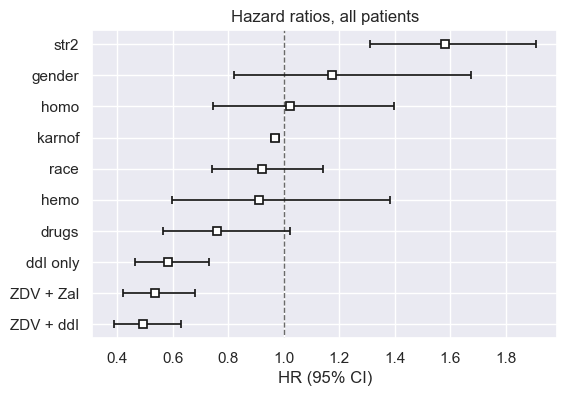

In [168]:
fig, ax = plt.subplots(figsize = (6, 4))
cph.plot(hazard_ratios=True, ax=ax)
ax.set_title("Hazard ratios, all patients")
# ax.set_xlim(0,1)

labels = [item.get_text() for item in ax.get_yticklabels()]
labels = [dict_cox_trt.get(label,label) for label in labels]

_ = ax.set_yticklabels(labels)

## E. With Regularization

### Plot how coefficients change with regularization strength

#### L2 Regularization

In [285]:
reg_strengths = 10.0 ** np.linspace(-4, 2, 60)
coefficients = {}

for reg in reg_strengths:
    cph = CoxPHFitter(penalizer=reg)
    cph.fit(X_cox_all_extra, duration_col = 'time', event_col = 'cid')
    key = round(reg, 5)
    coefficients[key] = cph.params_

coefficients = pd.DataFrame.from_dict(coefficients).rename_axis(index="feature", columns="regularization").set_index(
        X_cox_all_extra.drop(["time","cid"],axis=1).columns)

In [286]:
coefficients.head()

regularization,0.00010,0.00013,0.00016,0.00020,0.00026,0.00032,0.00041,0.00052,0.00065,0.00082,0.00104,0.00131,0.00166,0.00210,0.00265,0.00335,0.00424,0.00536,0.00677,0.00855,0.01081,0.01366,0.01727,0.02183,0.02759,0.03486,0.04406,0.05569,0.07038,0.08895,0.11242,0.14208,0.17957,0.22695,0.28683,0.36251,0.45816,0.57904,0.73182,0.92491,1.16895,1.47738,1.86718,2.35983,2.98247,3.76939,4.76394,6.02089,7.60950,9.61725,12.15474,15.36175,19.41492,24.53751,31.01169,39.19407,49.53535,62.60517,79.12343,100.00000
str2,0.458145,0.458086,0.458012,0.457919,0.457800,0.457651,0.457462,0.457224,0.456924,0.456545,0.456067,0.455465,0.454707,0.453753,0.452555,0.451052,0.449169,0.446818,0.443889,0.440253,0.435759,0.430233,0.423482,0.415295,0.405456,0.393753,0.380004,0.364073,0.345907,0.325558,0.303206,0.279174,0.253920,0.228012,0.202085,0.176781,0.152690,0.130297,0.109950,0.091842,0.076027,0.062444,0.050943,0.041326,0.033365,0.026833,0.021511,0.017199,0.013723,0.010931,0.008695,0.006909,0.005485,0.004351,0.003450,0.002735,0.002167,0.001716,0.001359,0.001076
trt_1,-0.705945,-0.705765,-0.705538,-0.705252,-0.704890,-0.704433,-0.703856,-0.703129,-0.702211,-0.701055,-0.699599,-0.697767,-0.695466,-0.692577,-0.688960,-0.684440,-0.678808,-0.671817,-0.663179,-0.652565,-0.639613,-0.623943,-0.605178,-0.582987,-0.557129,-0.527520,-0.494288,-0.457826,-0.418807,-0.378153,-0.336953,-0.296344,-0.257380,-0.220926,-0.187595,-0.157739,-0.131473,-0.108728,-0.089298,-0.072898,-0.059198,-0.047856,-0.038539,-0.030935,-0.024764,-0.019780,-0.015770,-0.012554,-0.009982,-0.007929,-0.006293,-0.004992,-0.003957,-0.003136,-0.002484,-0.001968,-0.001558,-0.001234,-0.000977,-0.000773
trt_2,-0.622613,-0.622448,-0.622239,-0.621975,-0.621641,-0.621221,-0.620689,-0.620019,-0.619174,-0.618109,-0.616768,-0.615081,-0.612960,-0.610299,-0.606966,-0.602802,-0.597613,-0.591171,-0.583212,-0.573431,-0.561497,-0.547060,-0.529778,-0.509350,-0.485567,-0.458369,-0.427901,-0.394562,-0.359019,-0.322168,-0.285059,-0.248769,-0.214273,-0.182344,-0.153494,-0.127974,-0.105810,-0.086856,-0.070859,-0.057505,-0.046460,-0.037395,-0.030005,-0.024012,-0.019174,-0.015284,-0.012165,-0.009671,-0.007681,-0.006096,-0.004835,-0.003833,-0.003038,-0.002406,-0.001906,-0.001509,-0.001195,-0.000946,-0.000749,-0.000593
trt_3,-0.538303,-0.538149,-0.537954,-0.537707,-0.537397,-0.537004,-0.536509,-0.535883,-0.535095,-0.534102,-0.532850,-0.531276,-0.529298,-0.526815,-0.523704,-0.519818,-0.514974,-0.508960,-0.501528,-0.492393,-0.481245,-0.467755,-0.451604,-0.432513,-0.410290,-0.384889,-0.356466,-0.325426,-0.292442,-0.258417,-0.224412,-0.191513,-0.160699,-0.132731,-0.108085,-0.086943,-0.069234,-0.054702,-0.042975,-0.033636,-0.026272,-0.020505,-0.016006,-0.012506,-0.009782,-0.007663,-0.006011,-0.004721,-0.003713,-0.002923,-0.002303,-0.001816,-0.001433,-0.001132,-0.000894,-0.000706,-0.000558,-0.000441,-0.000349,-0.000276
karnof,-0.032641,-0.032639,-0.032636,-0.032632,-0.032627,-0.032621,-0.032613,-0.032603,-0.032590,-0.032574,-0.032554,-0.032529,-0.032497,-0.032456,-0.032405,-0.032341,-0.032259,-0.032157,-0.032027,-0.031864,-0.031658,-0.031399,-0.031076,-0.030671,-0.030169,-0.029548,-0.028789,-0.027869,-0.026772,-0.025484,-0.024004,-0.022343,-0.020526,-0.018596,-0.016605,-0.014614,-0.012681,-0.010857,-0.009183,-0.007682,-0.006365,-0.005230,-0.004268,-0.003462,-0.002795,-0.002247,-0.001801,-0.001440,-0.001149,-0.000915,-0.000728,-0.000578,-0.000459,-0.000364,-0.000289,-0.000229,-0.000181,-0.000144,-0.000114,-0.000090


In [287]:
def plot_coefficients(coefs, n_highlight, type_r):
    _, ax = plt.subplots(figsize=(9, 6))
    alphas = coefs.columns
    for row in coefs.itertuples():
        ax.semilogx(alphas, row[1:], ".-", label=row.Index)

    alpha_min = alphas.min()
    top_coefs = coefs.loc[:, alpha_min].map(abs).sort_values().tail(n_highlight)
    for name in top_coefs.index:
        coef = coefs.loc[name, alpha_min]
        if name == "str2":
            name = "antiretroviral history"
        if name == "race":
            plt.text(alpha_min, coef, dict_cox_trt.get(name,name) + "   ", horizontalalignment="right", verticalalignment="bottom")
        else:
            plt.text(alpha_min, coef, dict_cox_trt.get(name,name) + "   ", horizontalalignment="right", verticalalignment="center")

    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    ax.grid(True)
    ax.set_xlabel("regularization strength")
    ax.set_ylabel("coefficient")
    ax.set_title(f"{type_r} regularization")


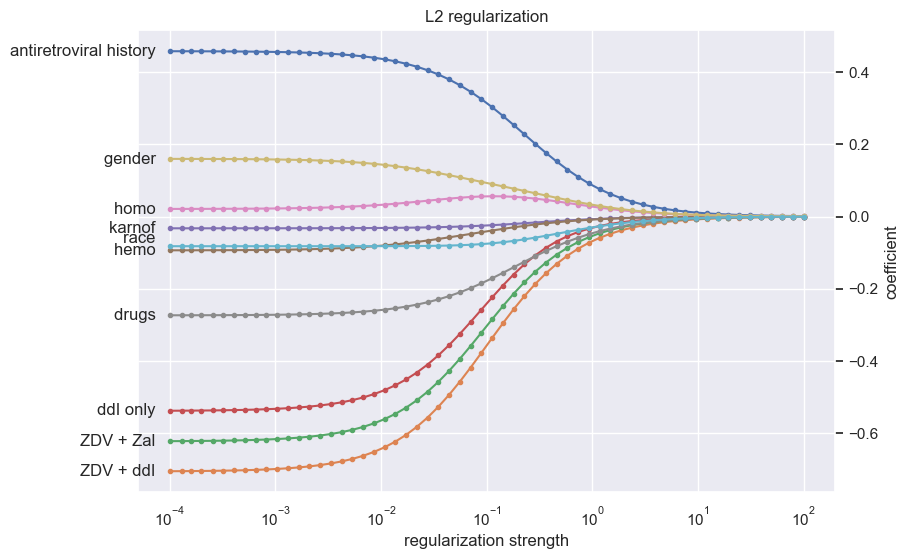

In [288]:
plot_coefficients(coefficients, n_highlight=10, type_r="L2")

In [289]:
coefficients_l1 = {}

for reg in reg_strengths:
    cph = CoxPHFitter(penalizer=reg, l1_ratio = 1.0)
    cph.fit(X_cox_all_extra, duration_col = 'time', event_col = 'cid')
    key = round(reg, 5)
    coefficients_l1[key] = cph.params_

coefficients_l1 = pd.DataFrame.from_dict(coefficients_l1).rename_axis(index="feature", columns="regularization").set_index(
        X_cox_all_extra.drop(["time","cid"],axis=1).columns)

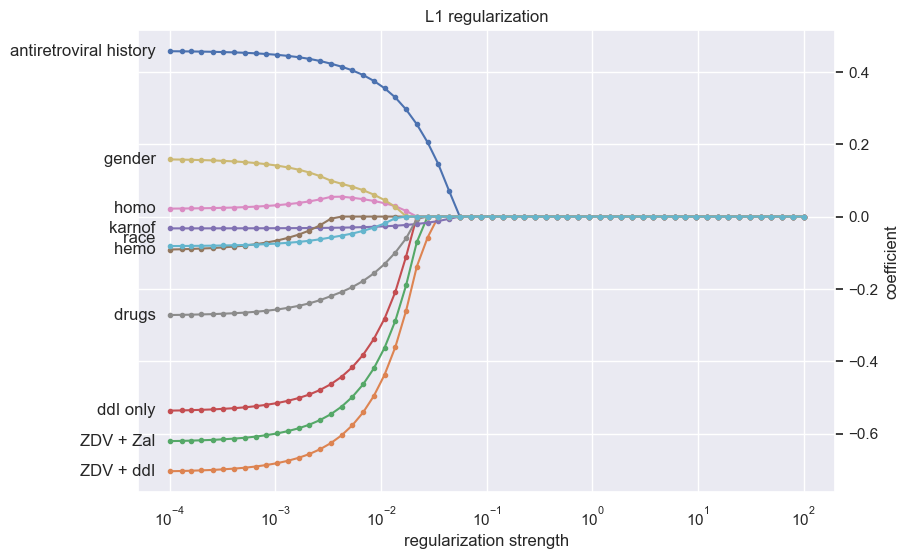

In [290]:
plot_coefficients(coefficients_l1, n_highlight=10, type_r="L1")

### Hyperparameter tuning: Cross Validation to choose regularization strength & L1 ratio

In [270]:
c_indices_reg = {}
l1_ratio = np.linspace(0, 1, 11)
reg_strengths_focused = 10.0 ** np.linspace(-4, 0, 40)

count = 0

# For each l1 ratio
for ratio in l1_ratio:
    # For each reg strength
    for reg in reg_strengths_focused:
        curr_c_indices = []
        cph = CoxPHFitter(penalizer=reg, l1_ratio=ratio)
        
        #  Perform cross validation   
        for train_index, test_index in kf.split(X_cox_all_extra):
            # 1. split    
            X_train, X_test = X_cox_all_extra.iloc[train_index], X_cox_all_extra.iloc[test_index]
            # 2. fit on training data
            cph.fit(X_train, duration_col = 'time', event_col = 'cid')
            # 3. error on testing data
            curr_c_indices.append(cph.score(X_test, 'concordance_index'))
        # Record
        c_indices_reg[count] = [ratio, reg, np.mean(curr_c_indices)]
        count += 1

In [271]:
c_indices_reg_df = pd.DataFrame.from_dict(c_indices_reg).rename_axis(index=None).transpose()
c_indices_reg_df.columns = ["L1 ratio", "Regularization strength", "CV score (Concordance index)"]
c_indices_reg_df.head()

,L1 ratio,Regularization strength,CV score (Concordance index)
0,0.0,0.000100,0.616335
1,0.0,0.000127,0.616270
2,0.0,0.000160,0.616270
3,0.0,0.000203,0.616283
4,0.0,0.000257,0.616397


In [272]:
c_indices_reg_df.to_excel(os.path.join(OUTPUT_DIR,"3E_Hyperparameter_tuning.xlsx"))

In [273]:
c_indices_reg_df_pivot = pd.pivot_table(c_indices_reg_df, index="Regularization strength", columns="L1 ratio")
c_indices_reg_df_pivot.to_excel(os.path.join(OUTPUT_DIR,"3E_Hyperparameter_tuning_pivot.xlsx"))

In [274]:
# find best performance
best_c_indices_reg_df = c_indices_reg_df.loc[c_indices_reg_df['CV score (Concordance index)'].idxmax()]
best_c_indices_reg_df

L1 ratio                        0.000000
Regularization strength         0.003455
CV score (Concordance index)    0.616571
Name: 15, dtype: float64

In [275]:
best_reg = best_c_indices_reg_df["Regularization strength"]
best_ratio = best_c_indices_reg_df["L1 ratio"]

#### Fit on all data for the final model

Above tuning suggests L2 regularization with strength = 0.003455 is chosen.

In [276]:
cph = CoxPHFitter(penalizer=best_reg, l1_ratio=best_ratio)
cph.fit(X_cox_all_extra, duration_col = 'time', event_col = 'cid')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 2139 total observations, 1618 right-censored observations>
             duration col = 'time'
                event col = 'cid'
                penalizer = 0.003455107294592218
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 2139
number of events observed = 521
   partial log-likelihood = -3816.54
         time fit was run = 2024-11-20 19:46:47 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
str2        0.45       1.57       0.10             0.26             0.64                 1.30                 1.89
trt_1      -0.68       0.50       0.12            -0.92            -0.44                 0.40                 0.64
trt_2      -0.60       0.55       0.12            -0.84            -0.37                 0.43                 0.69
trt_3      -0.52       0.59       0.11            -0.74            -0.30                 0.48                 0.74
karnof     -0.03       0.97       0.01            -0.05            -0.02                 0.95                 0.98
hemo       -0.09       0.92       0.21            -0.50             0.32                 0.61                 1.38
homo        0.03       1.03       0.16            -0.28             0.33                 0.76                 1.39
drugs      -0.27       0.76       0.15            -0.56             0.03                 0.57                 1.03
gender      0.15       1.17       0.18            -0.19             0.50                 0.82                 1.65
race       -0.08       0.92       0.11            -0.30             0.13                 0.74                 1.14

            cmp to     z      p   -log2(p)
covariate                                 
str2          0.00  4.73 <0.005      18.75
trt_1         0.00 -5.60 <0.005      25.52
trt_2         0.00 -5.01 <0.005      20.82
trt_3         0.00 -4.54 <0.005      17.43
karnof        0.00 -4.61 <0.005      17.92
hemo          0.00 -0.43   0.67       0.58
homo          0.00  0.16   0.87       0.20
drugs         0.00 -1.79   0.07       3.77
gender        0.00  0.87   0.38       1.38
race          0.00 -0.75   0.45       1.15
---
Concordance = 0.63
Partial AIC = 7653.08
log-likelihood ratio test = 98.33 on 10 df
-log2(p) of ll-ratio test = 52.91

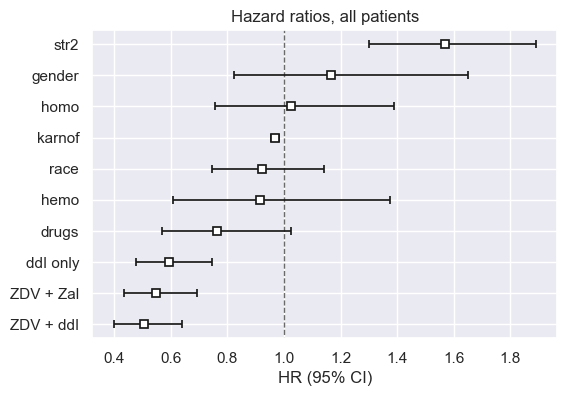

In [277]:
fig, ax = plt.subplots(figsize = (6, 4))
cph.plot(hazard_ratios=True, ax=ax)
ax.set_title("Hazard ratios, all patients")
# ax.set_xlim(0,1)

labels = [item.get_text() for item in ax.get_yticklabels()]
labels = [dict_cox_trt.get(label,label) for label in labels]

_ = ax.set_yticklabels(labels)

In [278]:
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 2139 total observations, 1618 right-censored observations>
             duration col = 'time'
                event col = 'cid'
                penalizer = 0.003455107294592218
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 2139
number of events observed = 521
   partial log-likelihood = -3816.54
         time fit was run = 2024-11-20 19:46:47 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
str2        0.45       1.57       0.10             0.26             0.64                 1.30                 1.89
trt_1      -0.68       0.50       0.12            -0.92            -0.44                 0.40                 0.64
trt_2      -0.60       0.55       0.12            -0.84            -0.37                 0.43                 0.69
trt_3      -0.52       0.59       0.11            -0.74            -0.30                 0.48                 0.74
karnof     -0.03       0.97       0.01            -0.05            -0.02                 0.95                 0.98
hemo       -0.09       0.92       0.21            -0.50             0.32                 0.61                 1.38
homo        0.03       1.03       0.16            -0.28             0.33                 0.76                 1.39
drugs      -0.27       0.76       0.15            -0.56             0.03                 0.57                 1.03
gender      0.15       1.17       0.18            -0.19             0.50                 0.82                 1.65
race       -0.08       0.92       0.11            -0.30             0.13                 0.74                 1.14

            cmp to     z      p   -log2(p)
covariate                                 
str2          0.00  4.73 <0.005      18.75
trt_1         0.00 -5.60 <0.005      25.52
trt_2         0.00 -5.01 <0.005      20.82
trt_3         0.00 -4.54 <0.005      17.43
karnof        0.00 -4.61 <0.005      17.92
hemo          0.00 -0.43   0.67       0.58
homo          0.00  0.16   0.87       0.20
drugs         0.00 -1.79   0.07       3.77
gender        0.00  0.87   0.38       1.38
race          0.00 -0.75   0.45       1.15
---
Concordance = 0.63
Partial AIC = 7653.08
log-likelihood ratio test = 98.33 on 10 df
-log2(p) of ll-ratio test = 52.91

In [279]:
# save to excel
_ = cox_result_excel(cph, "3E_Cox_result")

Text(0.5, 1.0, 'L2 regularization with chosen strength at 0.003455')

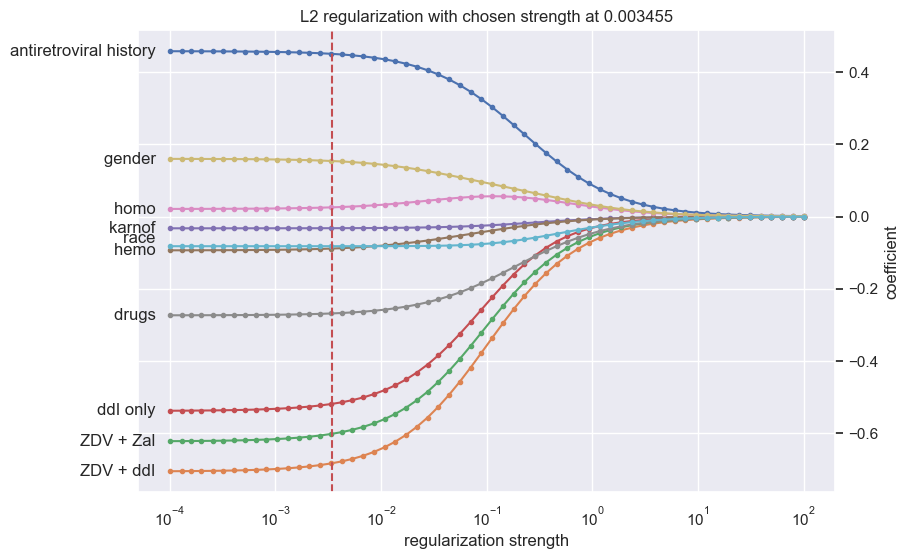

In [291]:
plot_coefficients(coefficients, n_highlight=10, type_r="L2")
plt.axvline(x = best_reg, color = 'r', linestyle="dashed", label="Chosen strength")
plt.title(f"L2 regularization with chosen strength at {best_reg:.6f}")
# plt.legend()